# Two-Tier Urban Deliveries with Robots with no time windows

## MIP model
##### Decision variables:

| Variable |    |
|------|------|
|   $x_{c}^{wrd} = 1$| if robot $r=1, ..., r_{max}$ from hub $d$ serves customer $c$, where $d=1, ..., n; c\in C_{d}^{\omega}; \omega \in \Omega$|
|$x_{c}^{wrd} = 0$|otherwise|
|$o^{d}=1$|if hub $d$ is opened where $d=1,...,n$|
|$o^{d}=0$:|otherwise|

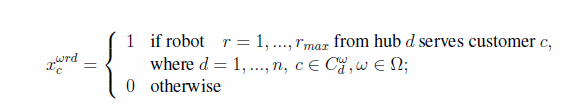

##### Objective Function
$$ min \sum_{d=1}^n o^{d}
$$


##### Constraints:
1.

| No. | Constraint   |
|------|------|
|   1  | table|

## Gurobi Model

In [1]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

#### Some custom functions for later use

In [2]:
def grid (a, n=None, spacing=None):
    """
    distribute n points evenly in a 2-dimensional square of side length a
    or create a square grid with suqare cells of length c
    """
    if spacing is None:
        assert n
        spacing = a // int(np.sqrt(n))
        base = range(spacing//2, a, spacing)
    if n is None:
        assert spacing
        base = range(0, a+1, spacing)
    return[(x,y) for x in base for y in base]

def travel_time(first: tuple, second:tuple, speed):
    """
    compute the travel time between first and second
    first, second: given as (x, y) tuples 
    speed: given in km/h
    """
    dist = abs(first[0] - second[0]) + abs(first[1] - second[1])  # Manhattan distance in m (!) because input is in meters
    return (dist/1000)/speed  # travel time in hours



#### Model inputs

In [3]:
n = 100  # number of clients
h = 16  # number of potential hubs (should be a square number (4, 9, 16, 25, ...) for an even distribution)
r_max = 5  # number of robots per hub
num_instances = 10

# downtown
area= 2000  # 2km * 2km square
block = 100  # 100m * 100m blocks

M = 6  # maximum allowed driving time per robot (hrs)
tf = 45/60  # robots' full recharge time (hrs)
b = 2  # robots' battery range (hrs)
ts = 4/60  # customer service time (hrs)
v = 3  # robot speed (km/h)

hubs_x , hubs_y = zip(*grid(a=area, n=h))

x, y = zip(*grid(a=area, spacing=block))
customers_x = np.random.choice(x, size=n)
customers_y = np.random.choice(y, size=n)

H = [i for i in range(h)]  # hubs
N = [i for i in range(n)]  # customers
R = [i for i in range(r_max)]  # robots

t = gp.tupledict()
for hub in H:
    for robot in R:
        for customer in N:
            t[hub, robot, customer] = 2*travel_time(first=(hubs_x[hub], hubs_y[hub]),
                                     second=(customers_x[customer], customers_y[customer]),
                                     speed=v)
            
reachables = [key for (key, value) in t.items() if value <=b]

#### Plotting the input data

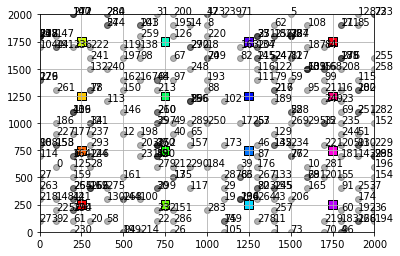

In [4]:
colors = plt.get_cmap('hsv', h)
plt.scatter(hubs_x, hubs_y, cmap=colors, c=H, marker='s', s=75, edgecolors='black')
plt.scatter(customers_x, customers_y, c='black', alpha=0.3)
for customer in N:
    plt.annotate(s=customer, xy=(customers_x[customer], customers_y[customer]))
plt.xlim(0, area)
plt.ylim(0, area)
plt.grid()

### Tier 1: Minimize the number of hubs

In [5]:
model1 = gp.Model('min_hubs')

Using license file C:\Users\steff\gurobi.lic
Academic license - for non-commercial use only


#### Add decision variables and define objective function

In [6]:
# add hub-robot-customer binary decision variables
x1 = model1.addVars(reachables, vtype=GRB.BINARY)

# add is-hub-open binary decision variables
o1 = model1.addVars(H, vtype=GRB.BINARY)

model1.setObjective(gp.quicksum(o1), sense=GRB.MINIMIZE)
model1.update()

In [7]:
x1.sum('*', '*', 17)

<gurobi.LinExpr: C17 + C310 + C603 + C896 + C1189 + C1482 + C1782 + C2082 + C2382 + C2682 + C2982 + C3282 + C3582 + C3882 + C4182 + C4480 + C4767 + C5054 + C5341 + C5628 + C5917 + C6217 + C6517 + C6817 + C7117 + C7417 + C7717 + C8017 + C8317 + C8617 + C8917 + C9217 + C9517 + C9817 + C10117 + C10417 + C10717 + C11017 + C11317 + C11617 + C11917 + C12217 + C12517 + C12817 + C13117 + C13417 + C13717 + C14017 + C14317 + C14617 + C14917 + C15217 + C15517 + C15817 + C16117 + C16417 + C16717 + C17017 + C17317 + C17617 + C17917 + C18203 + C18489 + C18775 + C19061 + C19347 + C19647 + C19947 + C20247 + C20547 + C20847 + C21147 + C21447 + C21747 + C22047 + C22347 + C22636 + C22925 + C23214 + C23503>

#### Adding constraints

In [8]:
# All customer locations must be assigned to exactly one hub-robot combination
for customer in N:
    model1.addConstr(x1.sum('*', '*', customer) == 1)

In [9]:
# limit on the maximum robot working time. First create a dictionary with the respective coefficients then add linear expression
coeff1 = gp.tupledict({
    (hub, robot, customer): t[hub, robot, customer]*(1+(tf/b))+ts
    for hub in H
    for robot in R
    for customer in N
})

for hub in H:
    for robot in R:
        model1.addConstr(x1.prod(coeff1, hub, robot, '*') <= M)

In [10]:
# if a robot serves a customer location (in some instance omega), the corresponding robot hub is open
for hub in H:  # eventually this must iterate over all customers assigned to one hub ('reachable')
    for customer in N:
        model1.addConstr(x1.sum(hub, '*', customer) <= o1.select(hub)[0])

#### Solve Model 1

In [11]:
model1.setParam('TimeLimit', 240)  # for testing only
model1.optimize()

Changed value of parameter TimeLimit to 240.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 5180 rows, 23791 columns and 76125 nonzeros
Model fingerprint: 0x2102625d
Variable types: 0 continuous, 23791 integer (23791 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 16.0000000
Presolve removed 45 rows and 0 columns
Presolve time: 0.08s
Presolved: 5135 rows, 23791 columns, 76080 nonzeros
Variable types: 0 continuous, 23791 integer (23791 binary)

Root relaxation: objective 1.005923e+00, 12203 iterations, 1.62 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.00592    0 4814   16.00000    1.00592  93.7%     -    3s
H    0     0       

#### Inspect and plot the solution

In [12]:
x1_solution = model1.getAttr('x', x1)
assignment1 = gp.tupledict({
    key[2]:(key[0], key[1]) 
    for key, value in x1_solution.items() 
    if value > 0.5})  # customer: (hub, robot)

In [13]:
o1_solution = model1.getAttr('x', o1)
open_hubs1 = [key for key, value in o1_solution.items() if value > 0.5]
p = len(open_hubs1)  # min number of open hubs
open_hubs1

[1, 3, 5, 13, 14, 15]

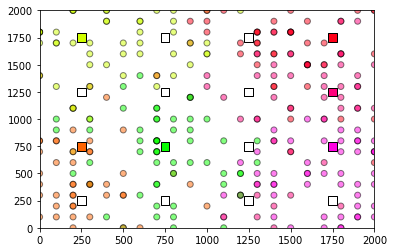

In [27]:
# colors = plt.get_cmap('hsv', p)
hub_colors = []
for hub in H:
    if o1_solution[hub] > 0.5:
        hub_colors.append(colors(hub/h))
    else:
        hub_colors.append('white')
plt.scatter(hubs_x, hubs_y, c=hub_colors, marker='s', s=75, edgecolors='black')

customer_colors = []
for customer in N:
    customer_colors.append(colors(assignment1[customer][0]/h))
plt.scatter(customers_x, customers_y, c=customer_colors, alpha=0.5, edgecolors='black')

if n <= 100:
    for customer in N:
        plt.annotate(s=customer, xy=(customers_x[customer], customers_y[customer]))
    
plt.xlim(0, area)
plt.ylim(0, area);
# plt.gcf().set_size_inches(20,10)

### Tier 2: Minimize operational robot cost

#### Model, decision variables, objective function

In [15]:
model2 = gp.Model('min_cost')
# add decision variables
x2 = model2.addVars(H, R, N, vtype=GRB.BINARY)
o2 = model2.addVars(H, vtype=GRB.BINARY)
model2.update()

In [16]:
# set the objective function
coeff2 = t
model2.setObjective(x2.prod(coeff2), sense=GRB.MINIMIZE)
model2.update()
# model2.getObjective()

#### Add constraints

In [17]:
# define the constraints
# All customer locations must be assigned to exactly one hub-robot combination (same as in first model)
for customer in N:
    model2.addConstr(x2.sum('*', '*', customer) == 1)

# limit the robot max working time (same as in first model)
for hub in H:
    for robot in R:
        model2.addConstr(x2.prod(coeff1, hub, robot, '*') <= M)
        
# Hub is open when one customer is served by any of its robots ????? (4) in paper
for hub in H:
    for customer in N:
        model2.addConstr(x2.sum(hub, '*', customer) <= o2.select(hub)[0])

# ensure that there are exactly as many open robot hubs as provided by first model
model2.addConstr(o2.sum() == p)

model2.update()

#### Solve Model 2

In [18]:
model2.optimize()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 5181 rows, 24016 columns and 76816 nonzeros
Model fingerprint: 0x2c1e26f5
Variable types: 0 continuous, 24016 integer (24016 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+00]
  Objective range  [7e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve time: 0.09s
Presolved: 5181 rows, 24016 columns, 76816 nonzeros
Variable types: 0 continuous, 24016 integer (24016 binary)

Root relaxation: objective 8.576667e+01, 1937 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   85.76667    0  243          -   85.76667      -     -    0s
H    0     0                      97.2666667   85.76667  11.8%     -    0s
     0     0   85.80000    0  250   97.26667   85.80000  11.8%     -    0s
H    0     0                      86.4666667   85

#### Inspect and plot solution of Model 2

In [19]:
objValue2 = model2.getObjective().getValue()
objValue2

85.86666666666675

In [20]:
x2_solution = model2.getAttr('x', x2)
# customer: (hub, robot) lookup dict
assignment2 = {
    key[2]: (key[0], key[1]) for key, value in x2_solution.items() if value > 0.5
}
assignment2
# test whether the constraints are satisfied: every customer is assigned to one robot and one hub
Counter([x2_solution.sum('*', '*', customer).getValue() == 1 for customer in N])

Counter({True: 300})

In [21]:
# test the constraints: maximum working time of robots
Counter([x2_solution.prod(coeff1, hub, robot, '*').getValue() <= M for hub in H for robot in R])

Counter({True: 80})

In [22]:
o2_solution = model2.getAttr('x', o2)
o2_solution
# test whether constraints are satisfied: only three hubs are open
o2_solution.sum().getValue() == p

True

In [23]:
workload = dict()
for hub in H:
    for robot in R:
        wl = x2_solution.sum(hub, robot, '*').getValue()
        if wl > 0:
            customers = [key for key, value in assignment2.items() if value == (hub, robot)]
            workload[hub, robot] = [customers,
                                    wl,
                                    x2_solution.prod(t, hub, robot, '*').getValue(),  # pure travel time
                                    x2_solution.prod(coeff1, hub, robot, '*').getValue()  # total time incl. recharge etc.
                                   ]
active_robots, wl_customers, wl_num_customers, wl_travel_time, wl_total_time = gp.multidict(workload)
wl_customers, wl_num_customers, wl_travel_time, wl_total_time

({(0, 0): [0, 20, 26, 28, 42, 58, 61, 114, 125, 141, 148, 214, 266, 268, 275],
  (0, 1): [22, 94, 124, 144, 153, 161, 188, 199, 273, 286, 294],
  (0, 2): [6, 27, 90, 225, 230],
  (0, 3): [100, 130, 158, 177, 254, 265],
  (0, 4): [92, 112, 159, 164, 169, 170, 218, 232, 263, 283],
  (3, 0): [50,
   54,
   104,
   107,
   118,
   139,
   140,
   222,
   236,
   238,
   242,
   272,
   277,
   280,
   284],
  (3, 1): [31, 44, 98, 101, 119, 147, 162, 167, 197, 226, 240, 259],
  (3, 2): [17, 78, 113, 138, 150, 241, 274],
  (3, 3): [41, 106, 132, 191],
  (3, 4): [179, 186, 243, 261],
  (5, 0): [37,
   45,
   65,
   87,
   89,
   135,
   142,
   156,
   160,
   198,
   203,
   252,
   290,
   296,
   297],
  (5, 1): [35, 48, 49, 64, 66, 120, 121, 146, 213, 287, 289],
  (5, 2): [3, 12, 40, 117, 151, 173, 184, 231, 250],
  (5, 3): [29, 34, 46, 83, 176, 212, 246, 260, 279, 293, 299],
  (5, 4): [13, 30, 39, 86, 97, 157, 172, 175, 210, 227, 237],
  (11, 0): [5, 33, 76, 102, 108, 111, 116, 122, 134,

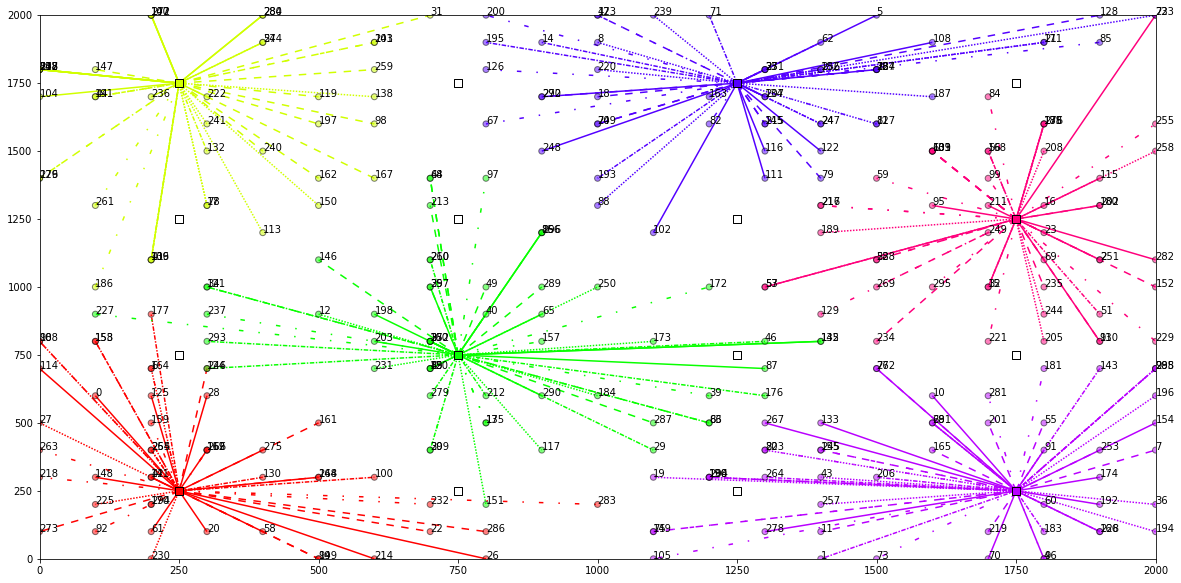

In [24]:
# plot hubs
hub_colors = []
for hub in H:
    if o2_solution[hub] > 0.5:
        hub_colors.append(colors(hub/h))
    else:
        hub_colors.append('white')
plt.scatter(hubs_x, hubs_y, c=hub_colors, marker='s', s=75, edgecolors='black')

# plot customers
customer_colors = []
for customer in N:
    customer_colors.append(colors(assignment2[customer][0]/h))
plt.scatter(customers_x, customers_y, c=customer_colors, alpha=0.5, edgecolors='black')

for customer in N:
    plt.annotate(s=customer, xy=(customers_x[customer], customers_y[customer]))

# plot robot tours, different line style per robot
dashes = [[1, 0], [5,5], [1,1], [3,1,1,1], [3,10,1,10]]  # may have to be extended for r_max > 5
for hub, robot in active_robots:
    C = wl_customers[hub, robot]
    for customer in C:
        plt.plot([hubs_x[hub], customers_x[customer]], [hubs_y[hub], customers_y[customer]],
                 c=hub_colors[hub], dashes=dashes[robot], zorder=0
                )

plt.xlim(0, area)
plt.ylim(0, area)
plt.gcf().set_size_inches(20,10)
# obviously, this plot does not show the actual tours which are based on manhatten distances

## List of questions
* Why is constraint (4) not used in the second model?
* How to implement the omega (multiple instances optimized simultaneously)